This jupyter notebook will give a short example of how differential privacy without post-processing is quite easy to handle for something as simple as a count that is the sum of noisy (protected) sub-counts.

In [19]:
#Loading Python modules
import numpy as np
import pandas as pd

Let's consider a city of about 8000 people in 2010: Montpelier, VT.

Here are the block populations of the city, courtesy of [data.census.gov](data.census.gov) and a [tract map of Washington County, Vermont](https://www2.census.gov/geo/maps/dc10map/tract/st50_vt/c50023_washington/DC10CT_C50023_001.pdf):

In [20]:
#Montpelier block populations, courtesy of data.census.gov and a tract map of the city:
mtplr = [80, 13, 0, 37, 0, 204, 2, 20, 0, 13, 25, 0, 0, 0,
         16, 9, 0, 0, 0, 0, 11, 92, 0, 34, 0, 0, 0, 75, 15,
         0, 50, 0, 0, 425, 0, 8, 0, 0, 0, 70, 56, 29, 5, 0,
         33, 0, 0, 0, 0, 50, 25, 0, 56, 46, 207, 0, 92, 22, 1,
         0, 34, 84, 0, 82, 1, 78, 67, 0, 45, 0, 6, 3, 0, 0,
         0, 17, 0, 15, 10, 0, 0, 25, 0, 38, 0, 218, 0, 12, 0,
         40, 0, 34, 0, 0, 86, 124, 0, 5, 23, 223, 0, 270, 0,
         0, 0, 0, 0, 127, 0, 31, 24, 0, 0, 57, 15, 24, 42, 0,
         0, 36, 0, 0, 0, 9, 0, 0, 0, 57, 35, 46, 0, 245, 39,
         137, 0, 23, 34, 0, 0, 18, 67, 35, 32, 46, 14, 15, 0,
         159, 23, 5, 19, 54, 165, 17, 103, 94, 46, 96, 75, 0,
         51, 0, 74, 29, 14, 6, 46, 153, 111, 0, 11, 45, 0, 0,
         4, 0, 14, 0, 0, 8, 0, 0, 87, 0, 3, 13, 0, 0, 11,
         45, 0, 9, 0, 0, 0, 0, 13, 0, 0, 4, 2, 0, 0, 0,
         58, 21, 357, 0, 60, 66, 30, 0, 0, 0, 0, 0, 0, 14,
         360, 0, 0, 0, 59, 0, 0, 0, 51, 0, 0, 6, 0, 0, 0,
         48, 0, 290, 0, 0, 74, 0, 49, 0, 2, 0, 28, 22, 0, 0,
         0, 0, 0, 0, 0, 82, 0]
mtplr = np.array(mtplr)

We now have the population of each block in Montpelier in 2010. Let's verify that the sum of the block populations [equals the total city population in 2010](https://data.census.gov/cedsci/table?q=Montpelier&g=1600000US5046000&hidePreview=false&tid=DECENNIALSF12010.P1&vintage=2018&layer=VT_2018_160_00_PY_D1&cid=DP05_0001E):

In [21]:
print(mtplr.sum())

7855


We'll now show how you get absolutely intelligble and reasonable output for the population of Montepelier using a basic diffentially private mechanism on the block populations, if you *do no post-processing*.

The current 2010 demonstration products give 0.12 budget to each block. Of that per-block budget, 30% goes to the total population. That gives us 0.12 x 0.30 = 0.036 privacy-loss budget for a given block population.

In [22]:
block_pop_budget = 0.12 * 0.3
print(block_pop_budget)

0.036


To make the block populations differentially private<sup>1</sup>, we can add Laplace noise with scale $\frac{1}{0.036}$ to the population of each block. A natural first question is then: what's the distribution of the population of Montpelier based upon adding up these noisy blocks *without* any post-processing? Let's do this 10,000 times and get a boxplot.

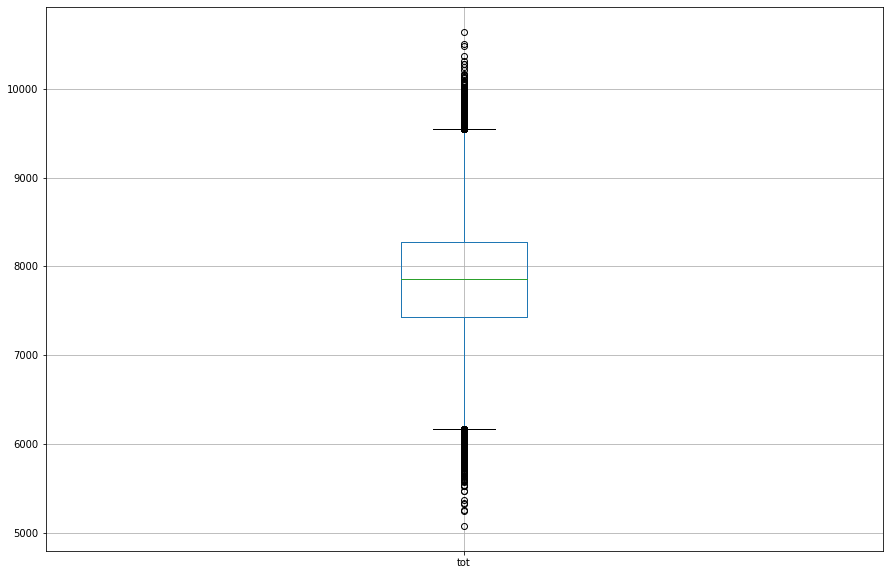

In [23]:
mtplr_totals = np.array([(mtplr + np.random.laplace(0, 1/block_pop_budget, len(mtplr))).sum()
                         for x in range(100000)])
ax = pd.DataFrame({'tot': mtplr_totals}).boxplot(figsize=(15,10))

Let's note a few things:

- The distribution is unbiased for the population of the city (with tolerance for only taking 10,000 draws)

In [24]:
print([mtplr.sum(), mtplr_totals.mean()])

[7855, 7855.380964509375]


- The observed standard deviation of the city population is very close to the theoretical value expected by adding the block-level variances: $\sqrt{\frac{2*\mbox{number_of_blocks}}{\mbox{budget}^2}}$

In [25]:
print([mtplr_totals.std(), np.sqrt(2*len(mtplr)/block_pop_budget/block_pop_budget)])

[627.5426774307816, 627.3105439242343]


- We can tell the mayor of the town **useful** things, including:
    - There is a ~50% chance that your pop will change by more than 425 people
    - There is a ~10% change that your pop will change by more than 810 people
    - There is a ~1% change that your pop will change by more than 1500 people

In [26]:
print(np.diff(np.quantile(mtplr_totals, [0.25, 0.75]))/2)
print(np.diff(np.quantile(mtplr_totals, [0.10, 0.90]))/2)
print(np.diff(np.quantile(mtplr_totals, [0.01, 0.99]))/2)

[421.90878572]
[804.83233949]
[1459.25505026]


With a bit more legwork, we should be able to compute the above numbers exactly just as with the standard deviation. In fact, the above calculations work if you consider **only the number of blocks**! The population of the city or of each block doesn't matter!

In [27]:
nblocks = len(mtplr)
total_block_noise = np.array([np.random.laplace(0, 1/block_pop_budget, nblocks).sum() for x in range(100000)])
print(np.diff(np.quantile(total_block_noise, [0.25, 0.75]))/2)
print(np.diff(np.quantile(total_block_noise, [0.10, 0.90]))/2)
print(np.diff(np.quantile(total_block_noise, [0.01, 0.99]))/2)

[423.78200232]
[802.5469463]
[1460.43091288]


What this means is that any city with the *same number of blocks* as Montpelier can expect the same kinds of results for their city population change due to adding up noisy blocks under this mechanism with no post-processing. Taking it further, this shows that smaller cities with lots of blocks will get more relative noise in this regime. But that makes sense, because if a small city has lots of blocks, then those blocks **can't be highly populated**, which means that block-level statistics are more likely to lead to issues, like uniqueness, that can aid re-identification and reconstruction.

All of these results become extremely hard or impossible to prove or even quantify if you start doing post-processing, including:
- Controlling any of the block totals or the city total to another count
- Controlling any of these counts within a larger optimization system
- Any non-data-dependent censoring of extremal values

Studying these complications is left as an exercise to the reader...

<sup>1</sup> Technically, adding Laplace noise on a computer is only differentially private if you avoid various pitfalls of floating point arithmetic and pseudo-random number generators. We can fix this most easily by using geometric noise instead, with the price of more complicated results for variance, quantiles, etc. This is also left as an exercise for the reader.